Cell 1: Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cell 2: Step 1 - Data Preparation

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_path = '/content/drive/MyDrive/Sem 6/Pothole/'
dataset_folder = os.path.join(base_path, 'Triall Dataset')
output_base_path = os.path.join(base_path, 'processed_dataset')

# Create output directories
train_images_dir = os.path.join(output_base_path, 'images/train')
train_labels_dir = os.path.join(output_base_path, 'labels/train')
val_images_dir = os.path.join(output_base_path, 'images/val')
val_labels_dir = os.path.join(output_base_path, 'labels/val')
test_images_dir = os.path.join(output_base_path, 'images/test')
test_labels_dir = os.path.join(output_base_path, 'labels/test')

for directory in [train_images_dir, train_labels_dir, val_images_dir, val_labels_dir, test_images_dir, test_labels_dir]:
    os.makedirs(directory, exist_ok=True)

# Get image files
image_extensions = ('.jpg', '.jpeg', '.png')
image_files = [f for f in os.listdir(dataset_folder) if f.lower().endswith(image_extensions)]

# Filter images with corresponding annotations
image_filenames = [f for f in image_files if os.path.exists(os.path.join(dataset_folder, os.path.splitext(f)[0] + '.txt'))]

# Split dataset
train_files, temp_files = train_test_split(image_filenames, train_size=0.7, random_state=42)
val_files, test_files = train_test_split(temp_files, train_size=0.5, random_state=42)

# Copy files function
def copy_files(file_list, image_dest_dir, label_dest_dir):
    for file in file_list:
        base_name = os.path.splitext(file)[0]
        shutil.copy2(os.path.join(dataset_folder, file), os.path.join(image_dest_dir, file))
        shutil.copy2(os.path.join(dataset_folder, base_name + '.txt'), os.path.join(label_dest_dir, base_name + '.txt'))
        print(f"Copied {file} and {base_name}.txt to {image_dest_dir}")

# Copy files
copy_files(train_files, train_images_dir, train_labels_dir)
copy_files(val_files, val_images_dir, val_labels_dir)
copy_files(test_files, test_images_dir, test_labels_dir)

# Print stats
print(f"Number of training images: {len(train_files)}")
print(f"Number of validation images: {len(val_files)}")
print(f"Number of test images: {len(test_files)}")
print(f"Total images processed: {len(train_files) + len(val_files) + len(test_files)}")

Copied img-856.jpg and img-856.txt to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/images/train
Copied img-1208.jpg and img-1208.txt to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/images/train
Copied img-684.jpg and img-684.txt to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/images/train
Copied img-930.jpg and img-930.txt to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/images/train
Copied img-528.jpg and img-528.txt to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/images/train
Copied img-452.jpg and img-452.txt to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/images/train
Copied img-1082.jpg and img-1082.txt to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/images/train
Copied img-419.jpg and img-419.txt to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/images/train
Copied img-4.jpg and img-4.txt to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/images/train
Copied img-1073.jpg and img-1073.txt to /conte

Cell 3: Step 2 - ROI Extraction with Cropping

In [ ]:
import os
import cv2
import numpy as np

# Define paths
base_path = '/content/drive/MyDrive/Sem 6/Pothole/'
output_base_path = os.path.join(base_path, 'processed_dataset')
subsets = {
    'train': {
        'images_dir': os.path.join(output_base_path, 'images/train'),
        'labels_dir': os.path.join(output_base_path, 'labels/train'),
        'visual_output_dir': os.path.join(base_path, 'visualized_images/train'),
        'cropped_images_dir': os.path.join(output_base_path, 'cropped_images/train'),
        'cropped_labels_dir': os.path.join(output_base_path, 'cropped_labels/train'),
        'roi_file': os.path.join(output_base_path, 'roi_points_train.txt')
    },
    'val': {
        'images_dir': os.path.join(output_base_path, 'images/val'),
        'labels_dir': os.path.join(output_base_path, 'labels/val'),
        'visual_output_dir': os.path.join(base_path, 'visualized_images/val'),
        'cropped_images_dir': os.path.join(output_base_path, 'cropped_images/val'),
        'cropped_labels_dir': os.path.join(output_base_path, 'cropped_labels/val'),
        'roi_file': os.path.join(output_base_path, 'roi_points_val.txt')
    }
}

# Create directories
for subset in subsets.values():
    os.makedirs(subset['visual_output_dir'], exist_ok=True)
    os.makedirs(subset['cropped_images_dir'], exist_ok=True)
    os.makedirs(subset['cropped_labels_dir'], exist_ok=True)

# ROI extraction with edge detection and cropping
def extract_roi_with_edges(image_path, label_path, output_image_path, cropped_image_path, cropped_label_path):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    image_with_boxes = image.copy()

    # Edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    with open(label_path, 'r') as f:
        bboxes = [list(map(float, line.strip().split())) for line in f.readlines()]

    if not bboxes:
        roi_points = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32)
        cropped_image = image
        cropped_h, cropped_w = h, w
        cropped_bboxes = bboxes
    else:
        pixel_boxes = []
        for bbox in bboxes:
            _, cx, cy, bw, bh = bbox
            x_min, y_min = int((cx - bw / 2) * w), int((cy - bh / 2) * h)
            x_max, y_max = int((cx + bw / 2) * w), int((cy + bh / 2) * h)
            pixel_boxes.append([x_min, y_min, x_max, y_max])
            cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

        pixel_boxes = np.array(pixel_boxes)
        x_min_all, y_min_all = np.min(pixel_boxes[:, 0]), np.min(pixel_boxes[:, 1])
        x_max_all, y_max_all = np.max(pixel_boxes[:, 2]), np.max(pixel_boxes[:, 3])

        # Refine ROI using edges
        roi_mask = edges[int(y_min_all):int(y_max_all), int(x_min_all):int(x_max_all)]
        if np.any(roi_mask):
            y, x = np.where(roi_mask)
            x_min_all, x_max_all = max(x_min_all, x_min_all + x.min()), min(x_max_all, x_min_all + x.max())
            y_min_all, y_max_all = max(y_min_all, y_min_all + y.min()), min(y_max_all, y_min_all + y.max())

        margin_x, margin_y = w * 0.2, h * 0.2
        x_min_roi = max(0, int(x_min_all - margin_x))
        y_min_roi = max(0, int(y_min_all - margin_y))
        x_max_roi = min(w - 1, int(x_max_all + margin_x))
        y_max_roi = min(h - 1, int(y_max_all + margin_y))

        roi_points = np.array([
            [x_min_roi, y_min_roi],
            [x_max_roi, y_min_roi],
            [x_max_roi, y_max_roi],
            [x_min_roi, y_max_roi]
        ], dtype=np.float32)

        # Crop the image
        cropped_image = image[y_min_roi:y_max_roi, x_min_roi:x_max_roi]
        cropped_h, cropped_w = cropped_image.shape[:2]
        cv2.imwrite(cropped_image_path, cropped_image)
        print(f"Saved cropped image to {cropped_image_path}")

        # Adjust labels for cropped image (keep partial boxes)
        cropped_bboxes = []
        for bbox in bboxes:
            _, cx, cy, bw, bh = bbox
            cx_pixel, cy_pixel = cx * w, cy * h
            new_cx = (cx_pixel - x_min_roi) / cropped_w
            new_cy = (cy_pixel - y_min_roi) / cropped_h
            new_bw = bw * w / cropped_w
            new_bh = bh * h / cropped_h
            # Clamp coordinates to [0, 1] instead of filtering out
            new_cx = max(0, min(1, new_cx))
            new_cy = max(0, min(1, new_cy))
            cropped_bboxes.append(f"{int(_)} {new_cx:.6f} {new_cy:.6f} {new_bw:.6f} {new_bh:.6f}")
        with open(cropped_label_path, 'w') as f:
            f.write('\n'.join(cropped_bboxes))
        print(f"Saved cropped label to {cropped_label_path}")

    cv2.polylines(image_with_boxes, [roi_points.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
    cv2.imwrite(output_image_path, image_with_boxes)
    print(f"Saved visualized image to {output_image_path}")
    return roi_points

# Process subsets
image_extensions = ('.jpg', '.jpeg', '.png')
for subset_name, paths in subsets.items():
    image_files = [f for f in os.listdir(paths['images_dir']) if f.lower().endswith(image_extensions)]
    roi_points_dict = {}

    for image_file in image_files:
        image_path = os.path.join(paths['images_dir'], image_file)
        label_path = os.path.join(paths['labels_dir'], os.path.splitext(image_file)[0] + '.txt')
        output_image_path = os.path.join(paths['visual_output_dir'], f"vis_{image_file}")
        cropped_image_path = os.path.join(paths['cropped_images_dir'], f"cropped_{image_file}")
        cropped_label_path = os.path.join(paths['cropped_labels_dir'], f"cropped_{os.path.splitext(image_file)[0]}.txt")

        roi_points = extract_roi_with_edges(image_path, label_path, output_image_path, cropped_image_path, cropped_label_path)
        roi_points_dict[image_file] = roi_points
        print(f"ROI points for {image_file} in {subset_name}: {roi_points}")

    with open(paths['roi_file'], 'w') as f:
        for image_file, points in roi_points_dict.items():
            points_str = ' '.join([f"{x:.2f},{y:.2f}" for x, y in points])
            f.write(f"{image_file}: {points_str}\n")

    print(f"Processed {len(roi_points_dict)} {subset_name} images.")

Streaming output truncated to the last 5000 lines.
Saved cropped image to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/cropped_images/train/cropped_img-1113.jpg
Saved cropped label to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/cropped_labels/train/cropped_img-1113.txt
Saved visualized image to /content/drive/MyDrive/Sem 6/Pothole/visualized_images/train/vis_img-1113.jpg
ROI points for img-1113.jpg in train: [[158.   0.]
 [393.   0.]
 [393. 132.]
 [158. 132.]]
Saved cropped image to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/cropped_images/train/cropped_img-233.jpg
Saved cropped label to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/cropped_labels/train/cropped_img-233.txt
Saved visualized image to /content/drive/MyDrive/Sem 6/Pothole/visualized_images/train/vis_img-233.jpg
ROI points for img-233.jpg in train: [[126.  62.]
 [613.  62.]
 [613. 545.]
 [126. 545.]]
Saved cropped image to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/cropp

Cell 4: Step 3 - Perspective Transformation on Cropped Images

In [ ]:
import os
import cv2
import numpy as np

# Define paths
base_path = '/content/drive/MyDrive/Sem 6/Pothole/'
output_base_path = os.path.join(base_path, 'processed_dataset')
subsets = {
    'train': {
        'cropped_images_dir': os.path.join(output_base_path, 'cropped_images/train'),
        'warped_images_dir': os.path.join(output_base_path, 'warped_images/train'),
        'roi_file': os.path.join(output_base_path, 'roi_points_train.txt'),
        'homography_file': os.path.join(output_base_path, 'homography_matrices_train.txt')
    },
    'val': {
        'cropped_images_dir': os.path.join(output_base_path, 'cropped_images/val'),
        'warped_images_dir': os.path.join(output_base_path, 'warped_images/val'),
        'roi_file': os.path.join(output_base_path, 'roi_points_val.txt'),
        'homography_file': os.path.join(output_base_path, 'homography_matrices_val.txt')
    }
}

# Create directories
for subset in subsets.values():
    os.makedirs(subset['warped_images_dir'], exist_ok=True)

# Warp cropped image with better interpolation
def warp_cropped_image(cropped_image_path, roi_points, output_warped_path):
    image = cv2.imread(cropped_image_path)
    h, w = image.shape[:2]

    # Adjust ROI points to cropped coordinates
    x_min, y_min = roi_points[0]  # Top-left corner of ROI in original image
    cropped_roi_points = roi_points - [x_min, y_min]  # Shift to cropped origin

    # Noise reduction
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # Color space conversion to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Histogram equalization on value channel
    h, s, v = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    v = clahe.apply(v)
    hsv = cv2.merge([h, s, v])
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Warp with INTER_CUBIC
    target_points = np.array([[0, 0], [799, 0], [799, 799], [0, 799]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(cropped_roi_points, target_points)
    warped_image = cv2.warpPerspective(image, M, (800, 800), flags=cv2.INTER_CUBIC)
    cv2.imwrite(output_warped_path, warped_image)
    print(f"Saved warped image to {output_warped_path}")
    return M

# Process subsets
image_extensions = ('.jpg', '.jpeg', '.png')
for subset_name, paths in subsets.items():
    roi_points_dict = {}
    with open(paths['roi_file'], 'r') as f:
        for line in f:
            image_file, points_str = line.strip().split(': ')
            points = [list(map(float, pt.split(','))) for pt in points_str.split()]
            roi_points_dict[image_file] = np.array(points, dtype=np.float32)

    image_files = [f for f in os.listdir(paths['cropped_images_dir']) if f.lower().endswith(image_extensions)]
    homography_dict = {}

    for image_file in image_files:
        original_file = image_file.replace('cropped_', '')
        cropped_image_path = os.path.join(paths['cropped_images_dir'], image_file)
        output_warped_path = os.path.join(paths['warped_images_dir'], f"warped_{original_file}")

        if original_file in roi_points_dict:
            M = warp_cropped_image(cropped_image_path, roi_points_dict[original_file], output_warped_path)
            homography_dict[original_file] = M
            print(f"Processed {image_file} in {subset_name} with homography matrix: {M}")

    with open(paths['homography_file'], 'w') as f:
        for image_file, M in homography_dict.items():
            M_str = ' '.join(map(str, M.flatten()))
            f.write(f"{image_file}: {M_str}\n")

    print(f"Processed {len(homography_dict)} {subset_name} images.")

Saved warped image to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/warped_images/train/warped_img-856.jpg
Processed cropped_img-856.jpg in train with homography matrix: [[2.37797619 0.         0.        ]
 [0.         2.08072917 0.        ]
 [0.         0.         1.        ]]
Saved warped image to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/warped_images/train/warped_img-1208.jpg
Processed cropped_img-1208.jpg in train with homography matrix: [[0.5901034  0.         0.        ]
 [0.         0.63162055 0.        ]
 [0.         0.         1.        ]]
Saved warped image to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/warped_images/train/warped_img-684.jpg
Processed cropped_img-684.jpg in train with homography matrix: [[2.40662651 0.         0.        ]
 [0.         1.5018797  0.        ]
 [0.         0.         1.        ]]
Saved warped image to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/warped_images/train/warped_img-930.jpg
Processed cropped_

Cell 5: Step 4 - Annotation Adjustment for Warped Images

In [ ]:
import os
import cv2
import numpy as np

# Define paths
base_path = '/content/drive/MyDrive/Sem 6/Pothole/'
output_base_path = os.path.join(base_path, 'processed_dataset')
subsets = {
    'train': {
        'cropped_labels_dir': os.path.join(output_base_path, 'cropped_labels/train'),
        'cropped_images_dir': os.path.join(output_base_path, 'cropped_images/train'),
        'warped_labels_dir': os.path.join(output_base_path, 'warped_labels/train'),
        'warped_images_dir': os.path.join(output_base_path, 'warped_images/train'),
        'visualized_dir': os.path.join(base_path, 'visualized_warped/train'),
        'homography_file': os.path.join(output_base_path, 'homography_matrices_train.txt')
    },
    'val': {
        'cropped_labels_dir': os.path.join(output_base_path, 'cropped_labels/val'),
        'cropped_images_dir': os.path.join(output_base_path, 'cropped_images/val'),
        'warped_labels_dir': os.path.join(output_base_path, 'warped_labels/val'),
        'warped_images_dir': os.path.join(output_base_path, 'warped_images/val'),
        'visualized_dir': os.path.join(base_path, 'visualized_warped/val'),
        'homography_file': os.path.join(output_base_path, 'homography_matrices_val.txt')
    }
}

# Create directories
for subset in subsets.values():
    os.makedirs(subset['warped_labels_dir'], exist_ok=True)
    os.makedirs(subset['warped_images_dir'], exist_ok=True)
    os.makedirs(subset['visualized_dir'], exist_ok=True)

# Adjust annotations and visualize warped images
def adjust_warped_annotations(cropped_label_path, cropped_image_path, homography_matrix, output_label_path, warped_image_path, visualized_image_path):
    # Get cropped image dimensions
    cropped_image = cv2.imread(cropped_image_path)
    cropped_h, cropped_w = cropped_image.shape[:2]

    # Load warped image for visualization (with correct naming)
    warped_image = cv2.imread(warped_image_path)
    if warped_image is None:
        print(f"Error: Warped image not found at {warped_image_path}")
        return
    warped_h, warped_w = warped_image.shape[:2]  # Should be 800x800

    with open(cropped_label_path, 'r') as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
        class_id, cx, cy, bw, bh = map(float, line.strip().split())
        # Convert normalized coordinates to pixel coordinates in cropped image
        x_center, y_center = cx * cropped_w, cy * cropped_h
        box_w, box_h = bw * cropped_w, bh * cropped_h
        # Define the four corners of the bounding box
        x1, y1 = x_center - box_w / 2, y_center - box_h / 2
        x2, y2 = x_center + box_w / 2, y_center + box_h / 2
        corners = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=np.float32)
        # Apply homography to all corners
        warped_corners = cv2.perspectiveTransform(corners[None, :, :], homography_matrix)[0]
        # Compute new bounding box from warped corners
        x_min, y_min = np.min(warped_corners[:, 0]), np.min(warped_corners[:, 1])
        x_max, y_max = np.max(warped_corners[:, 0]), np.max(warped_corners[:, 1])
        new_cx = (x_min + x_max) / 2 / warped_w
        new_cy = (y_min + y_max) / 2 / warped_h
        new_bw = (x_max - x_min) / warped_w
        new_bh = (y_max - y_min) / warped_h
        # Clamp coordinates to [0, 1]
        new_cx = max(0, min(1, new_cx))
        new_cy = max(0, min(1, new_cy))
        new_bw = max(0, min(1, new_bw))
        new_bh = max(0, min(1, new_bh))
        # Only include if box has non-zero area
        if new_bw > 0 and new_bh > 0:
            new_lines.append(f"{int(class_id)} {new_cx:.6f} {new_cy:.6f} {new_bw:.6f} {new_bh:.6f}")
            # Draw bounding box on warped image
            x_min_pixel = int(x_min)
            y_min_pixel = int(y_min)
            x_max_pixel = int(x_max)
            y_max_pixel = int(y_max)
            cv2.rectangle(warped_image, (x_min_pixel, y_min_pixel), (x_max_pixel, y_max_pixel), (0, 255, 0), 2)
            cv2.putText(warped_image, "pothole", (x_min_pixel, y_min_pixel - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    if new_lines:  # Only write if there are valid annotations
        with open(output_label_path, 'w') as f:
            f.write('\n'.join(new_lines))
        print(f"Saved warped label to {output_label_path}")
        # Save visualized warped image in separate folder
        cv2.imwrite(visualized_image_path, warped_image)
        print(f"Saved visualized warped image to {visualized_image_path}")
    else:
        print(f"Warning: No valid annotations for {output_label_path} after warping")

# Process subsets
for subset_name, paths in subsets.items():
    homography_dict = {}
    with open(paths['homography_file'], 'r') as f:
        for line in f:
            image_file, M_str = line.strip().split(': ')
            M = np.array(list(map(float, M_str.split())), dtype=np.float32).reshape(3, 3)
            homography_dict[image_file] = M

    label_files = [f for f in os.listdir(paths['cropped_labels_dir']) if f.endswith('.txt')]
    for label_file in label_files:
        original_file = label_file.replace('cropped_', '')
        cropped_label_path = os.path.join(paths['cropped_labels_dir'], label_file)
        cropped_image_path = os.path.join(paths['cropped_images_dir'], f"cropped_{original_file.replace('.txt', '.jpg')}")
        output_label_path = os.path.join(paths['warped_labels_dir'], original_file)
        # Adjust warped_image_path to include 'warped_' prefix
        warped_image_name = f"warped_{original_file.replace('.txt', '.jpg')}"
        warped_image_path = os.path.join(paths['warped_images_dir'], warped_image_name)
        visualized_image_path = os.path.join(paths['visualized_dir'], warped_image_name.replace('.jpg', '_visualized.jpg'))

        if original_file.replace('.txt', '.jpg') in homography_dict:
            adjust_warped_annotations(
                cropped_label_path,
                cropped_image_path,
                homography_dict[original_file.replace('.txt', '.jpg')],
                output_label_path,
                warped_image_path,
                visualized_image_path
            )

Saved warped label to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/warped_labels/train/img-856.txt
Saved visualized warped image to /content/drive/MyDrive/Sem 6/Pothole/visualized_warped/train/warped_img-856_visualized.jpg
Saved warped label to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/warped_labels/train/img-1208.txt
Saved visualized warped image to /content/drive/MyDrive/Sem 6/Pothole/visualized_warped/train/warped_img-1208_visualized.jpg
Saved warped label to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/warped_labels/train/img-684.txt
Saved visualized warped image to /content/drive/MyDrive/Sem 6/Pothole/visualized_warped/train/warped_img-684_visualized.jpg
Saved warped label to /content/drive/MyDrive/Sem 6/Pothole/processed_dataset/warped_labels/train/img-930.txt
Saved visualized warped image to /content/drive/MyDrive/Sem 6/Pothole/visualized_warped/train/warped_img-930_visualized.jpg
Saved warped label to /content/drive/MyDrive/Sem 6/Pothole/process

Cell 7: Step 6 - Training YOLOv8 with Augmentation

Found existing installation: torch 2.5.0
Uninstalling torch-2.5.0:
  Successfully uninstalled torch-2.5.0
Found existing installation: torchvision 0.20.0
Uninstalling torchvision-0.20.0:
  Successfully uninstalled torchvision-0.20.0
Found existing installation: torchaudio 2.5.0
Uninstalling torchaudio-2.5.0:
  Successfully uninstalled torchaudio-2.5.0
Found existing installation: ultralytics 8.3.93
Uninstalling ultralytics-8.3.93:
  Successfully uninstalled ultralytics-8.3.93
Looking in links: https://download.pytorch.org/whl/cu124/torch_stable.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 200.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 295.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 330.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 277.2 MB/s eta 0:00:00


PyTorch version: 2.5.0+cu124
CUDA available: True
Device count: 1
GPU name: Tesla T4
Copied train images and labels to /content/drive/MyDrive/Sem 6/Pothole/yolo_train
Copied val images and labels to /content/drive/MyDrive/Sem 6/Pothole/yolo_val
Starting fresh training with yolov8x.pt
Training on device: cuda


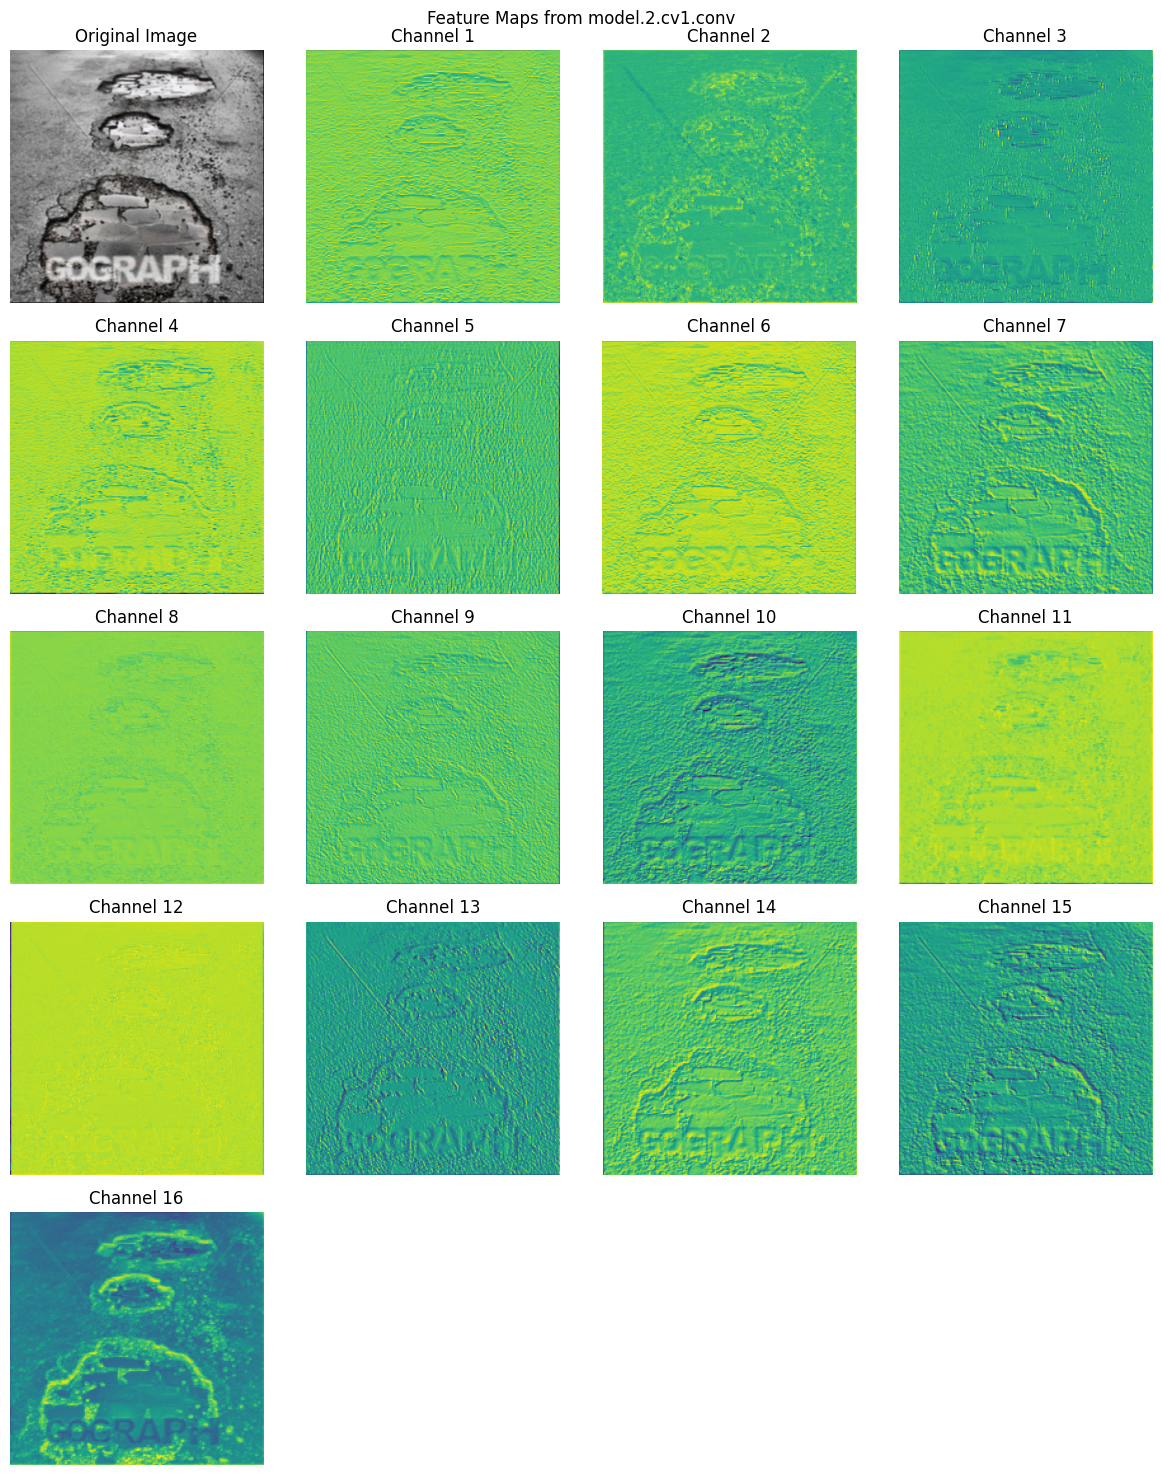

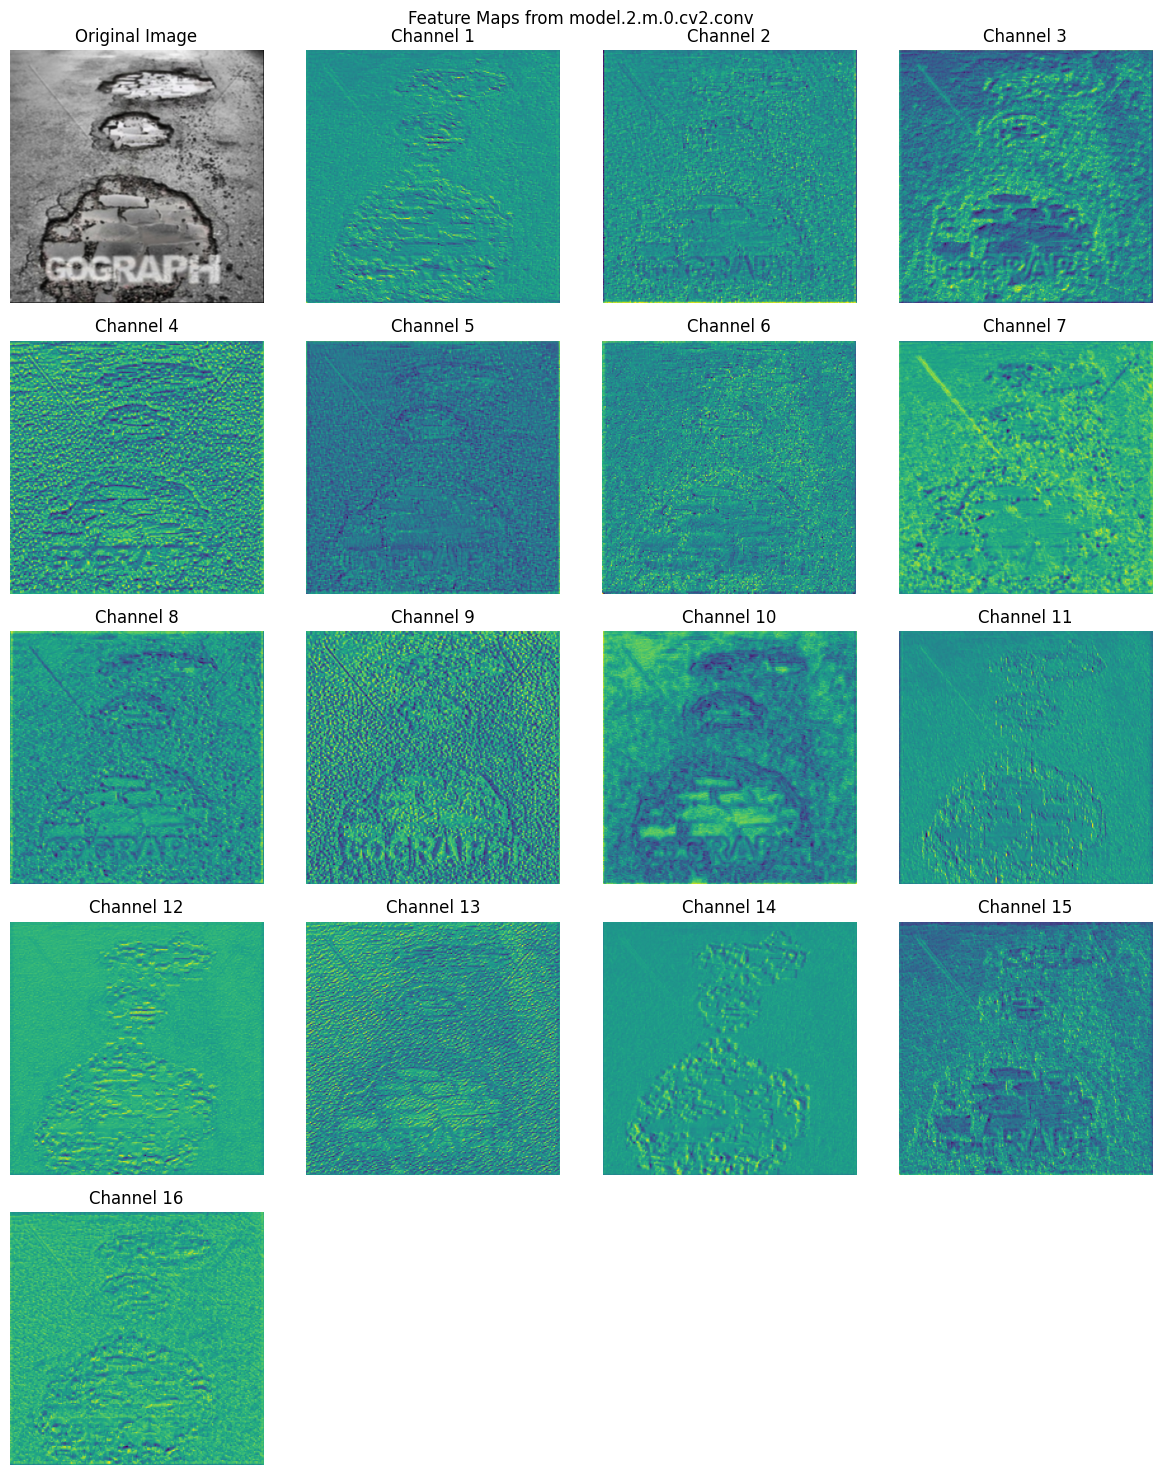

New https://pypi.org/project/ultralytics/8.3.113 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.93 🚀 Python-3.11.12 torch-2.5.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/drive/MyDrive/Sem 6/Pothole/data.yaml, epochs=25, time=None, patience=100, batch=8, imgsz=800, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/content/drive/MyDrive/Sem 6/Pothole/, name=pothole_training, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes

100%|██████████| 755k/755k [00:00<00:00, 78.4MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 204MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Sem 6/Pothole/yolo_train... 875 images, 0 backgrounds, 0 corrupt: 100%|██████████| 875/875 [00:18<00:00, 47.90it/s] 


train: New cache created: /content/drive/MyDrive/Sem 6/Pothole/yolo_train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Sem 6/Pothole/yolo_val... 187 images, 0 backgrounds, 0 corrupt: 100%|██████████| 187/187 [00:04<00:00, 46.25it/s] 


val: New cache created: /content/drive/MyDrive/Sem 6/Pothole/yolo_val.cache
Plotting labels to /content/drive/MyDrive/Sem 6/Pothole/pothole_training/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Sem 6/Pothole/pothole_training
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      10.3G      2.009      2.881      2.225         16        800: 100%|██████████| 110/110 [01:50<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]

                   all        187        569      0.434      0.374      0.314      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.8G      1.766       2.16       1.98         17        800: 100%|██████████| 110/110 [01:48<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

                   all        187        569      0.525      0.388      0.388      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.8G      1.711      2.064      1.881         10        800: 100%|██████████| 110/110 [01:54<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

                   all        187        569      0.449      0.306      0.309      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.8G      1.757      1.958      1.881         10        800: 100%|██████████| 110/110 [01:51<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]

                   all        187        569      0.432      0.385      0.381      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.8G      1.809      1.906       1.94          7        800: 100%|██████████| 110/110 [01:52<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]

                   all        187        569      0.498      0.334      0.348       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.8G      1.838       1.94      2.007         15        800: 100%|██████████| 110/110 [01:50<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]

                   all        187        569       0.41      0.357      0.328      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.8G      1.803      1.948      1.999         23        800: 100%|██████████| 110/110 [01:51<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

                   all        187        569      0.539      0.434      0.441        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.8G      1.794      1.853      1.963          6        800: 100%|██████████| 110/110 [01:54<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

                   all        187        569      0.587      0.455      0.506      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.8G      1.763      1.819      1.938         16        800: 100%|██████████| 110/110 [01:55<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]

                   all        187        569      0.562      0.478      0.494      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.8G      1.732       1.73      1.926         18        800: 100%|██████████| 110/110 [01:51<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]

                   all        187        569      0.592      0.485      0.512      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.8G      1.728      1.716      1.925         29        800: 100%|██████████| 110/110 [01:54<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

                   all        187        569      0.648      0.448      0.543      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.8G      1.709      1.663      1.899         23        800: 100%|██████████| 110/110 [01:54<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

                   all        187        569       0.63      0.478       0.56      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.8G       1.69      1.613      1.894         20        800: 100%|██████████| 110/110 [01:54<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

                   all        187        569      0.649      0.513      0.566       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.8G      1.646      1.542      1.867         14        800: 100%|██████████| 110/110 [01:54<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

                   all        187        569      0.639      0.514      0.569      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.8G      1.651      1.555      1.868          7        800: 100%|██████████| 110/110 [01:50<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]

                   all        187        569      0.651      0.503      0.571      0.292


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.8G      1.681      1.514      1.973         13        800: 100%|██████████| 110/110 [01:56<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]

                   all        187        569      0.704      0.538      0.614      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.8G      1.631      1.487      1.941         11        800: 100%|██████████| 110/110 [01:54<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]

                   all        187        569      0.684      0.541      0.612      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.8G      1.617      1.358      1.923          4        800: 100%|██████████| 110/110 [01:50<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]

                   all        187        569      0.707       0.51      0.622      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.8G      1.626      1.325      1.909          6        800: 100%|██████████| 110/110 [01:54<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

                   all        187        569      0.677      0.542      0.616      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.8G      1.575      1.326      1.859          4        800: 100%|██████████| 110/110 [01:51<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]

                   all        187        569      0.687      0.548      0.635      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.8G      1.534      1.261      1.848         10        800: 100%|██████████| 110/110 [01:53<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]

                   all        187        569      0.685      0.559      0.624      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.8G      1.508      1.249      1.836          6        800: 100%|██████████| 110/110 [01:54<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]

                   all        187        569      0.663      0.571      0.639      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.8G       1.48      1.174      1.785          7        800: 100%|██████████| 110/110 [01:54<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]

                   all        187        569      0.733      0.534       0.64      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.8G      1.455      1.136      1.766         10        800: 100%|██████████| 110/110 [01:54<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

                   all        187        569      0.732      0.561      0.653      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.8G      1.438      1.112      1.757         14        800: 100%|██████████| 110/110 [01:54<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]

                   all        187        569      0.734      0.575      0.665      0.348



25 epochs completed in 0.867 hours.
Optimizer stripped from /content/drive/MyDrive/Sem 6/Pothole/pothole_training/weights/last.pt, 136.7MB
Optimizer stripped from /content/drive/MyDrive/Sem 6/Pothole/pothole_training/weights/best.pt, 136.7MB

Validating /content/drive/MyDrive/Sem 6/Pothole/pothole_training/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.11.12 torch-2.5.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


                   all        187        569      0.736      0.573      0.665      0.348
Speed: 0.5ms preprocess, 39.9ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to /content/drive/MyDrive/Sem 6/Pothole/pothole_training
Ultralytics 8.3.93 🚀 Python-3.11.12 torch-2.5.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /content/drive/MyDrive/Sem 6/Pothole/yolo_val.cache... 187 images, 0 backgrounds, 0 corrupt: 100%|██████████| 187/187 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:26<00:00,  1.11s/it]


                   all        187        569      0.736      0.575      0.665      0.349
Speed: 4.9ms preprocess, 111.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/drive/MyDrive/Sem 6/Pothole/pothole_training2
mAP@0.5: 0.6652
mAP@0.5:0.95: 0.3494


In [ ]:
# Uninstall any existing packages to start fresh
!pip uninstall -y torch torchvision torchaudio ultralytics

# Install CUDA 12.4 compatible versions for T4 GPU
!pip install \
  torch==2.5.0 \
  torchvision==0.20.0 \
  torchaudio==2.5.0 \
  ultralytics==8.3.93 \
  -f https://download.pytorch.org/whl/cu124/torch_stable.html \
  --no-cache-dir

import os
import shutil
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision import transforms

# Verify PyTorch and GPU setup
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device count: {torch.cuda.device_count()}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

# Define paths
base_path = '/content/drive/MyDrive/Sem 6/Pothole/'
output_base_path = os.path.join(base_path, 'processed_dataset')
yolo_train_dir = os.path.join(base_path, 'yolo_train')
yolo_val_dir = os.path.join(base_path, 'yolo_val')
weights_dir = os.path.join(base_path, 'pothole_training/weights')

# Copy files with matching names (skip if already done)
def copy_to_yolo_folders():
    for subset in ['train', 'val']:
        src_image_dir = os.path.join(output_base_path, f'warped_images/{subset}')
        src_label_dir = os.path.join(output_base_path, f'warped_labels/{subset}')
        dest_dir = yolo_train_dir if subset == 'train' else yolo_val_dir
        os.makedirs(dest_dir, exist_ok=True)

        for image_file in os.listdir(src_image_dir):
            if image_file.endswith(('.jpg', '.jpeg', '.png')):
                shutil.copy2(os.path.join(src_image_dir, image_file), os.path.join(dest_dir, image_file))

        for label_file in os.listdir(src_label_dir):
            if label_file.endswith('.txt'):
                new_label_file = f"warped_{label_file}"
                shutil.copy2(os.path.join(src_label_dir, label_file), os.path.join(dest_dir, new_label_file))

        print(f"Copied {subset} images and labels to {dest_dir}")

# Check if YOLO folders are populated
if not os.path.exists(yolo_train_dir) or not os.listdir(yolo_train_dir):
    copy_to_yolo_folders()
else:
    print("YOLO folders already populated, skipping copy.")

# Configure data.yaml
data_yaml = f"""
train: {yolo_train_dir}
val: {yolo_val_dir}
nc: 1
names: ['pothole']
"""
data_yaml_path = os.path.join(base_path, 'data.yaml')
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml)

# Load model: Always start fresh with yolov8x.pt
print("Starting fresh training with yolov8x.pt")
model = YOLO('yolov8x.pt')

# Use GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on device: {device}")

# Function to visualize feature maps with original image
def visualize_feature_maps(feature_maps, layer_name, original_img, num_channels=16):
    feature_maps = feature_maps.squeeze(0).cpu().detach().numpy()  # Shape: [C, H, W]
    num_channels = min(num_channels, feature_maps.shape[0])

    # Create a grid of feature maps, including space for original image
    total_plots = num_channels + 1  # +1 for original image
    cols = 4
    rows = int(np.ceil(total_plots / cols))
    plt.figure(figsize=(12, 3 * rows))

    # Plot original image in the first subplot
    plt.subplot(rows, cols, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    # Plot feature maps
    for i in range(num_channels):
        plt.subplot(rows, cols, i + 2)  # Start from second subplot
        feature_map = feature_maps[i]
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min() + 1e-8)  # Normalize
        plt.imshow(feature_map, cmap='viridis')
        plt.title(f'Channel {i+1}')
        plt.axis('off')
    plt.suptitle(f'Feature Maps from {layer_name}')
    plt.tight_layout()
    plt.show()

# Hook to capture intermediate feature maps
feature_maps = {}
def hook_fn(module, input, output, layer_name):
    feature_maps[layer_name] = output

# Register hooks for two important layers
model.model.eval()  # Set to eval to inspect architecture
model_module = model.model
model_module.to(device)  # Move model to the same device as input
layer_names = []
for name, module in model_module.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        layer_names.append(name)

# Select two important layers (e.g., early and mid-level conv layers)
selected_layers = [layer_names[2], layer_names[5]]  # Adjust indices based on model architecture
hooks = []
for layer_name in selected_layers:
    layer = dict(model_module.named_modules())[layer_name]
    hooks.append(layer.register_forward_hook(lambda m, i, o, ln=layer_name: hook_fn(m, i, o, ln)))

# Load a sample image
sample_image_path = os.path.join(yolo_train_dir, os.listdir(yolo_train_dir)[0])
img = cv2.imread(sample_image_path)
if img is None:
    raise FileNotFoundError(f"Sample image not found at {sample_image_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)

# Run a forward pass to capture feature maps
with torch.no_grad():
    _ = model.model(img_tensor)
for layer_name in selected_layers:
    visualize_feature_maps(feature_maps[layer_name], layer_name, original_img=img)

# Remove hooks
for hook in hooks:
    hook.remove()

# Set model back to train mode
model.model.train()

# Train for all 50 epochs
model.train(
    data=data_yaml_path,
    epochs=25,
    batch=8,
    imgsz=800,
    optimizer='SGD',
    lr0=0.01,
    project=base_path,
    name='pothole_training',
    exist_ok=False,
    device=device,
    verbose=True,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    flipud=0.5
)

# Validate and print accuracy
val_results = model.val()
print(f"mAP@0.5: {val_results.box.map50:.4f}")
print(f"mAP@0.5:0.95: {val_results.box.map:.4f}")

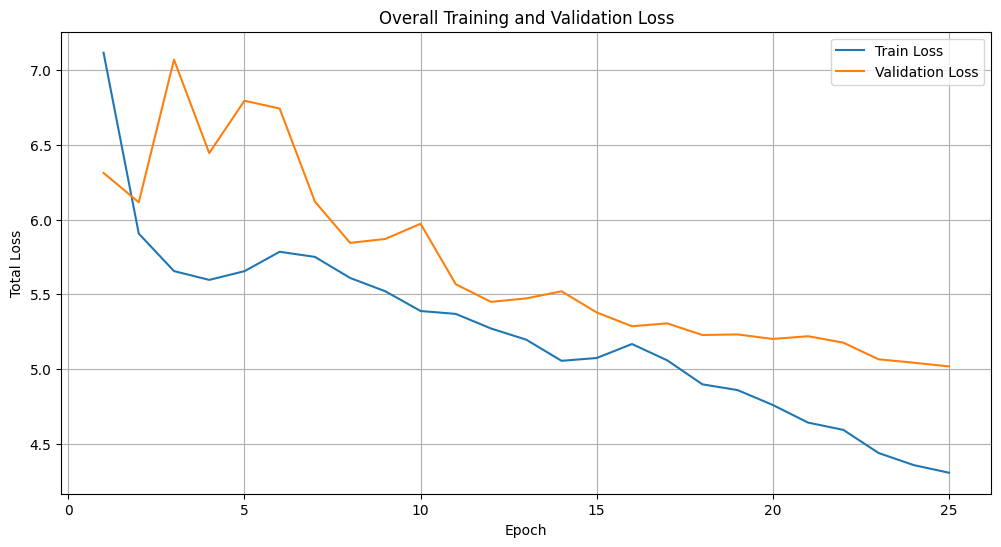

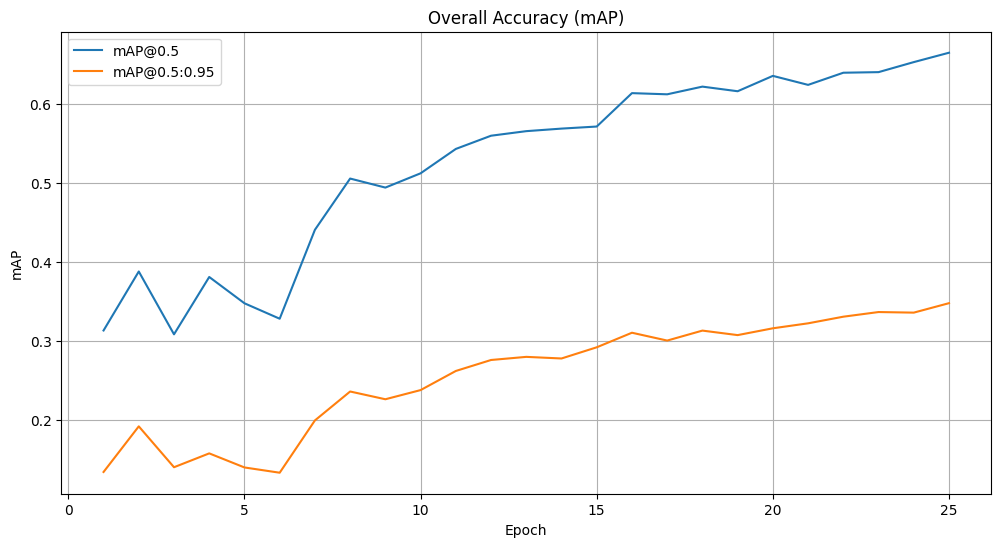

mAP@0.5: 66.52%
mAP@0.5:0.95: 34.94%


In [ ]:
# Cell 8: Plot Overall Loss and Accuracy Graphs, Print Accuracy in Percentage
import pandas as pd
import matplotlib.pyplot as plt

# Define paths
base_path = '/content/drive/MyDrive/Sem 6/Pothole/'
results_csv_path = os.path.join(base_path, 'pothole_training/results.csv')

# Read results.csv
try:
    results_df = pd.read_csv(results_csv_path)
except FileNotFoundError:
    print(f"Error: results.csv not found at {results_csv_path}")
    results_df = None

if results_df is not None:
    # Calculate overall training and validation loss
    results_df['train/total_loss'] = (
        results_df['train/box_loss'] +
        results_df['train/cls_loss'] +
        results_df['train/dfl_loss']
    )
    results_df['val/total_loss'] = (
        results_df['val/box_loss'] +
        results_df['val/cls_loss'] +
        results_df['val/dfl_loss']
    )

    # Plot Overall Loss Graph
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['epoch'], results_df['train/total_loss'], label='Train Loss')
    plt.plot(results_df['epoch'], results_df['val/total_loss'], label='Validation Loss')
    plt.title('Overall Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Overall Accuracy Graph (using mAP@0.5)
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP@0.5')
    plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
    plt.title('Overall Accuracy (mAP)')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.legend()
    plt.grid(True)
    plt.show()

# Print accuracy in percentage
map50_percent = val_results.box.map50 * 100
map_percent = val_results.box.map * 100
print(f"mAP@0.5: {map50_percent:.2f}%")
print(f"mAP@0.5:0.95: {map_percent:.2f}%")

Cell 8: Step 7 - Save Model

In [ ]:
import os
import shutil

# Define paths
base_path = '/content/drive/MyDrive/Sem 6/Pothole/'
best_model_path = os.path.join(base_path, 'pothole_training/weights/best.pt')
saved_model_path = os.path.join(base_path, 'yolov5_best.pt')

# Save model
if os.path.exists(best_model_path):
    shutil.copy2(best_model_path, saved_model_path)
    print(f"Saved trained model to {saved_model_path}")
else:
    print(f"Warning: Best model not found at {best_model_path}. Training may have failed.")

Saved trained model to /content/drive/MyDrive/Sem 6/Pothole/yolov5_best.pt


Step 7 (Original Step 8): test

In [ ]:
import os
!pip install ultralytics==8.3.93

import cv2
from ultralytics import YOLO

# Define paths
base_path = '/content/drive/MyDrive/Sem 6/Pothole'
test_images_dir = os.path.join(base_path, 'DiverseDataset')
results_dir = os.path.join(base_path, 'results')
model_path = os.path.join(base_path, 'yolov5_best.pt')

# Create results directory
os.makedirs(results_dir, exist_ok=True)

# Load the trained model
model = YOLO(model_path)

# Test the model on test images
image_extensions = ('.jpg', '.jpeg', '.png')
test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(image_extensions)]

for image_file in test_images:
    image_path = os.path.join(test_images_dir, image_file)
    output_path = os.path.join(results_dir, f"bounded_{image_file}")

    # Run inference
    results = model.predict(image_path, imgsz=800, device='cpu')

    # Draw bounding boxes on the image
    img = cv2.imread(image_path)
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            conf = box.conf[0]  # Confidence score
            label = f"pothole {conf:.2f}"
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Save the bounded image
    cv2.imwrite(output_path, img)
    print(f"Saved bounded image to {output_path}")


image 1/1 /content/drive/MyDrive/Sem 6/Pothole/DiverseDataset/img-471.jpg: 608x800 18 potholes, 4387.1ms
Speed: 3.7ms preprocess, 4387.1ms inference, 25.7ms postprocess per image at shape (1, 3, 608, 800)
Saved bounded image to /content/drive/MyDrive/Sem 6/Pothole/results/bounded_img-471.jpg

image 1/1 /content/drive/MyDrive/Sem 6/Pothole/DiverseDataset/img-382.jpg: 544x800 4 potholes, 2751.1ms
Speed: 4.5ms preprocess, 2751.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 800)
Saved bounded image to /content/drive/MyDrive/Sem 6/Pothole/results/bounded_img-382.jpg

image 1/1 /content/drive/MyDrive/Sem 6/Pothole/DiverseDataset/img-1231.jpg: 608x800 1 pothole, 3260.4ms
Speed: 5.1ms preprocess, 3260.4ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 800)
Saved bounded image to /content/drive/MyDrive/Sem 6/Pothole/results/bounded_img-1231.jpg

image 1/1 /content/drive/MyDrive/Sem 6/Pothole/DiverseDataset/img-1208.jpg: 608x800 2 potholes, 3842.2ms
Speed: 7.1ms pr